<a href="https://colab.research.google.com/github/venkat2ram/Keras-and-Tensorflow/blob/master/Gold_price_Tme_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [108]:
#data_pd=pd.read_csv("/content/Gold_Prices.csv")
data_pd=pd.read_csv("/content/Hasbros_Stock_History.csv")

In [109]:
data_pd.head()

,Day,Price
0,1,0.10535
1,2,0.09877
2,3,0.10974
3,4,0.10755
4,5,0.10535


In [110]:
data_np=data_pd.to_numpy()

In [111]:
data_np

array([[1.0000e+00, 1.0535e-01],
       [2.0000e+00, 9.8770e-02],
       [3.0000e+00, 1.0974e-01],
       ...,
       [1.0214e+04, 7.8510e+01],
       [1.0215e+04, 8.0410e+01],
       [1.0216e+04, 7.9910e+01]])

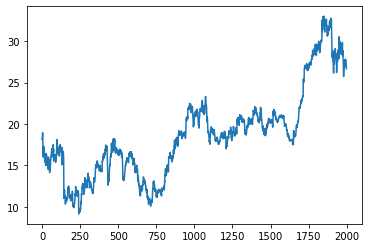

In [112]:
plt.plot(data_np[5000:7000,1])

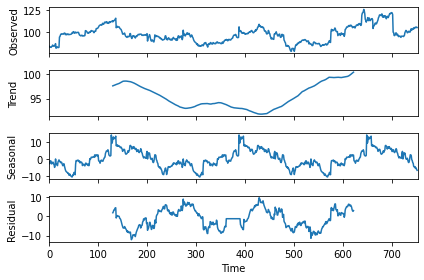

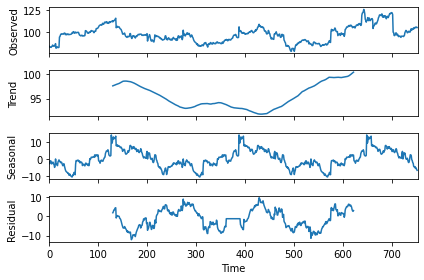

In [113]:
decomp=seasonal_decompose(data_np[9283:10036,1],freq=261,model='additive')
decomp.plot()

In [114]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [115]:
time=data_np[:9700,0]
series=data_np[:9700,1]
split_time = 7000
train_time=time[:split_time]
valid_time=time[split_time:]
train_series=series[:split_time]
valid_series=series[split_time:]

In [116]:
window_size=300
train_data=window_dataset(train_series,window_size)
valid_data=window_dataset(valid_series,window_size)

In [117]:
keras.backend.clear_session()

In [118]:
model=tf.keras.Sequential([tf.keras.layers.Dense(100,input_shape=[window_size]),
                           tf.keras.layers.Dense(1)])


In [119]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.000001,momentum=0.9),loss=keras.losses.Huber(),metrics=["mae"])

In [120]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               30100     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 30,201
Trainable params: 30,201
Non-trainable params: 0
_________________________________________________________________


In [121]:
model.fit(train_data,epochs=100,validation_data=valid_data)

Epoch 1/100
210/210 [==============================] - 5s 23ms/step - loss: 0.9228 - mae: 1.3006 - val_loss: 4.1268 - val_mae: 4.6049
Epoch 2/100
210/210 [==============================] - 5s 23ms/step - loss: 0.8521 - mae: 1.2145 - val_loss: 3.9967 - val_mae: 4.4724
Epoch 3/100
210/210 [==============================] - 5s 23ms/step - loss: 0.8294 - mae: 1.1894 - val_loss: 4.0632 - val_mae: 4.5369
Epoch 4/100
210/210 [==============================] - 5s 22ms/step - loss: 0.8130 - mae: 1.1714 - val_loss: 3.9072 - val_mae: 4.3792
Epoch 5/100
210/210 [==============================] - 5s 22ms/step - loss: 0.7977 - mae: 1.1557 - val_loss: 3.7962 - val_mae: 4.2697
Epoch 6/100
210/210 [==============================] - 5s 22ms/step - loss: 0.7795 - mae: 1.1348 - val_loss: 3.7387 - val_mae: 4.2127
Epoch 7/100
210/210 [==============================] - 5s 22ms/step - loss: 0.7675 - mae: 1.1220 - val_loss: 3.7056 - val_mae: 4.1777
Epoch 8/100
210/210 [==============================] - 5s 22ms

In [122]:
def model_forecast(model,series,window_size):
  dataset=tf.data.Dataset.from_tensor_slices(series)
  dataset=dataset.window(size=window_size, shift=1,drop_remainder=True)
  dataset=dataset.flat_map(lambda w: w.batch(window_size))
  dataset=dataset.batch(32).prefetch(1)
  lin_forecast=model.predict(dataset)
  return lin_forecast

In [123]:
#lin_forecast=model_forecast(model,series[split_time-window_size:-1],window_size)
lin_forecast=model_forecast(model,data_np[8000-window_size:-1,1],window_size)

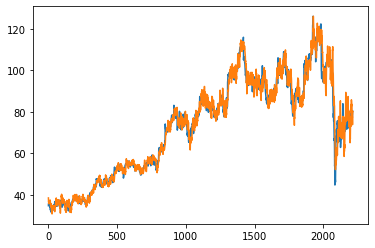

In [124]:
#plt.plot(valid_time,valid_series)
#plt.plot(valid_time,lin_forecast)
plt.plot(data_np[8000:-1,1])
plt.plot(lin_forecast)
plt.show()

In [125]:
lin_forecast

array([[38.520905],
       [36.447903],
       [36.634212],
       ...,
       [73.813896],
       [80.27124 ],
       [80.12558 ]], dtype=float32)

# Reinforcement Learning:

In [126]:
initial_data=data_np[9700-window_size-1:9700,1]

In [127]:
initial_data=data_np[9700-window_size-1:9700,1]
rein_data=initial_data
pred_rein=np.zeros(500,dtype=float)
for i in range(0,500):
  rein_forecast=model_forecast(model,rein_data[:-1],window_size)
  rein_data=np.append(rein_data[1:],rein_forecast)
  input_rein=window_dataset(rein_data,window_size,batch_size=1,shuffle_buffer=1)
  model.fit(input_rein,epochs=3,validation_data=valid_data)
  pred_rein[i]=rein_forecast
  

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 1s 1s/step - loss: 8.8652 - mae: 9.3652 - val_loss: 22.7873 - val_mae: 23.2873
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 1.6959 - mae: 2.1959 - val_loss: 16.0470 - val_mae: 16.5470
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 6.9959 - mae: 7.4959 - val_loss: 12.2399 - val_mae: 12.7399
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 12.4780 - mae: 12.9780 - val_loss: 11.0723 - val_mae: 11.5723
Epoch 10/10
1/1 [==============================] - 1s 1s/step - loss: 14.1719 - mae: 14.6719 - val_loss: 12.2799 - val_mae: 12.7799
Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 4.6770 - mae: 5.1770 - val_loss: 11.1172 - val_mae: 11.6171
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 2.9818 - mae: 3.4818 - val_loss: 7.8232 - val_mae: 8.3226
Epoch 3/10
1/1 [==============================] - 1s 1

In [128]:
pred_rein

array([ 9.86658401e+01,  1.01720146e+02,  1.07434738e+02,  1.04301353e+02,
        8.60820084e+01,  8.09410248e+01,  7.26077805e+01,  7.04619675e+01,
        7.11058121e+01,  7.58676300e+01,  7.54734726e+01,  7.99325562e+01,
        6.86386871e+01,  6.18309479e+01,  4.71970062e+01,  5.27654915e+01,
        5.37770920e+01,  6.08496475e+01,  6.01611137e+01,  6.17574692e+01,
        7.36905060e+01,  6.41001740e+01,  6.08858795e+01,  5.51088486e+01,
        5.39790535e+01,  5.28445435e+01,  5.67292709e+01,  5.62256927e+01,
        6.26384621e+01,  6.14217796e+01,  5.09602737e+01,  5.13072357e+01,
        5.17134247e+01,  4.69859123e+01,  3.69718437e+01,  3.63292007e+01,
        3.69007835e+01,  3.85492706e+01,  4.79252625e+01,  5.14664421e+01,
        5.38488045e+01,  7.24885635e+01,  7.58366852e+01,  6.64580307e+01,
        5.78900261e+01,  6.49743347e+01,  7.05774078e+01,  7.33179245e+01,
        8.15550461e+01,  8.03198166e+01,  7.61327744e+01,  8.79130478e+01,
        8.61906509e+01,  

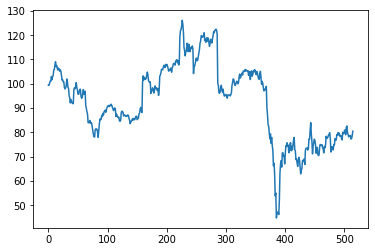

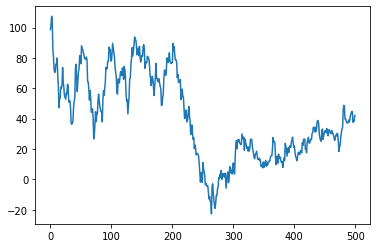

In [129]:
plt.clf()
plt.plot(data_np[9700:-1,1])
plt.show()
plt.plot(pred_rein[:])
plt.show()

In [130]:
b=model_forecast(model,initial_data[:-1],window_size)

In [131]:
x=window_dataset(initial_data,window_size,batch_size=1,shuffle_buffer=1)

In [132]:
for a in x.take(1):
  print(a)

(<tf.Tensor: shape=(1, 300), dtype=float64, numpy=
array([[110.47, 111.91, 111.84, 110.42, 110.82, 110.06, 111.51, 110.74,
        112.  , 111.12, 111.93, 112.13, 112.3 , 112.97, 111.74, 113.14,
        112.84, 113.4 , 114.04, 114.9 , 115.95, 105.  , 106.32, 106.1 ,
        106.64, 105.74, 105.88, 105.95, 104.77, 103.94, 103.49, 103.02,
        101.43, 100.  ,  97.82,  97.55,  98.24,  98.33,  98.96,  97.16,
         95.51,  94.84,  94.55,  93.92,  95.05,  95.2 ,  94.63,  94.83,
         95.28,  98.25,  98.34,  95.52,  93.66,  92.67,  94.09,  95.8 ,
         94.92,  95.96,  95.07,  94.84,  93.24,  94.99,  95.52,  94.84,
         96.14,  96.6 ,  97.42,  97.16,  97.01,  97.67,  97.65,  97.57,
         97.68,  96.58,  96.26,  96.62,  96.19,  96.61,  96.6 ,  96.62,
         97.13,  96.56,  96.72,  96.67,  98.19,  89.75,  92.96,  94.4 ,
         94.93,  97.14,  95.47,  92.59,  90.47,  89.61,  90.69,  91.01,
         89.89,  89.01,  88.69,  91.45,  96.83,  95.98,  94.75,  95.9 ,
         95.8

In [133]:
initial_data[len(initial_data)-1:]=b

In [134]:
initial_data

array([110.47      , 111.91      , 111.84      , 110.42      ,
       110.82      , 110.06      , 111.51      , 110.74      ,
       112.        , 111.12      , 111.93      , 112.13      ,
       112.3       , 112.97      , 111.74      , 113.14      ,
       112.84      , 113.4       , 114.04      , 114.9       ,
       115.95      , 105.        , 106.32      , 106.1       ,
       106.64      , 105.74      , 105.88      , 105.95      ,
       104.77      , 103.94      , 103.49      , 103.02      ,
       101.43      , 100.        ,  97.82      ,  97.55      ,
        98.24      ,  98.33      ,  98.96      ,  97.16      ,
        95.51      ,  94.84      ,  94.55      ,  93.92      ,
        95.05      ,  95.2       ,  94.63      ,  94.83      ,
        95.28      ,  98.25      ,  98.34      ,  95.52      ,
        93.66      ,  92.67      ,  94.09      ,  95.8       ,
        94.92      ,  95.96      ,  95.07      ,  94.84      ,
        93.24      ,  94.99      ,  95.52      ,  94.84

In [135]:
initial_data[99:]

array([ 91.45      ,  96.83      ,  95.98      ,  94.75      ,
        95.9       ,  95.89      ,  95.02      ,  95.05      ,
        95.03      ,  94.65      ,  93.7       ,  93.78      ,
        92.84      ,  93.02      ,  91.84      ,  92.14      ,
        91.11      ,  90.81      ,  91.35      ,  91.36      ,
        91.67      ,  92.02      ,  95.45      ,  95.87      ,
        94.07      ,  91.55      ,  91.67      ,  91.11      ,
        92.84      ,  93.55      ,  92.8       ,  91.67      ,
        91.52      ,  90.89      ,  92.08      ,  91.29      ,
        90.71      ,  92.41      ,  93.17      ,  93.94      ,
        92.31      ,  92.41      ,  92.45      ,  91.39      ,
        91.62      ,  90.52      ,  92.56      ,  90.86      ,
        94.56      ,  95.77      ,  95.55      ,  93.39      ,
        94.2       ,  94.27      ,  94.57      ,  95.74      ,
        94.12      ,  91.33      ,  93.93      , 102.22      ,
        96.48      ,  97.73      ,  96.63      ,  95.56

In [136]:
b

array([[112.306854]], dtype=float32)